In [ ]:
!pip install cartopy
!pip install dash

In [ ]:
import json
import pandas as pd
import pyproj
from shapely.geometry import Point, shape
from geopy.distance import distance
import datetime
import numpy as np
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import seaborn as sb

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from dash.dependencies import Input, Output

<ipython-input-4-46d6479ab48e>:15: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-4-46d6479ab48e>:16: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [ ]:
# Load datasets and GeoJSON
climate_df = pd.read_csv('/content/drive/MyDrive/ERA5_spain_df.csv')
drought_df = pd.read_csv('/content/drive/MyDrive/drought_index_spain.csv')

with open('/content/drive/MyDrive/iberiaLow.json') as f:
    geojson_data = json.load(f)

In [ ]:
climate_df

,longitude,latitude,time,u10,v10,t2m,evabs,lai_hv,lai_lv,src,skt,e,tp,coords
0,-9.445992,38.867001,2020-05-01,3.112254,1.182039,290.67790,-0.000911,2.500040,3.104129,2.321904e-07,297.62506,-0.002715,0.000331,POINT (-9.445992469787598 38.867000579833984)
1,-9.445992,38.867001,2020-05-02,2.924212,-1.948506,291.35153,-0.001068,2.500040,3.102900,0.000000e+00,299.05222,-0.002949,0.000043,POINT (-9.445992469787598 38.867000579833984)
2,-9.445992,38.867001,2020-05-03,1.525630,4.767544,296.05438,-0.001309,2.500040,3.101535,0.000000e+00,300.45930,-0.003603,0.000001,POINT (-9.445992469787598 38.867000579833984)
3,-9.445992,38.867001,2020-05-04,4.789202,5.436440,291.23680,-0.000754,2.500040,3.100238,2.729939e-08,296.05900,-0.002481,0.000775,POINT (-9.445992469787598 38.867000579833984)
4,-9.445992,38.867001,2020-05-05,2.901390,3.720486,291.23610,-0.000800,2.500040,3.099009,4.466681e-06,297.16006,-0.002528,0.000808,POINT (-9.445992469787598 38.867000579833984)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563069,3.355000,35.966000,2022-08-27,-0.048780,-3.161503,303.68597,-0.000258,2.048205,1.055939,5.462789e-08,307.00073,-0.000334,0.000008,POINT (3.3550000190734863 35.965999603271484)
2563070,3.355000,35.966000,2022-08-28,0.418915,-2.303011,306.44702,-0.000250,2.047209,1.055530,0.000000e+00,309.08887,-0.000321,0.000017,POINT (3.3550000190734863 35.965999603271484)
2563071,3.355000,35.966000,2022-08-29,1.914250,-1.568631,304.06442,-0.000191,2.046295,1.055325,3.703128e-05,304.76242,-0.000495,0.001151,POINT (3.3550000190734863 35.965999603271484)
2563072,3.355000,35.966000,2022-08-30,-1.113386,-2.211128,306.12430,-0.000248,2.045299,1.055052,0.000000e+00,308.77322,-0.000668,0.000069,POINT (3.3550000190734863 35.965999603271484)


In [ ]:
drought_df

In [ ]:
# ! Takes 10 minutes
# Transform projected coordinates from paper to latitude and longitude
utm_zone = 30
ellipsoid = 'intl'
utm_to_latlon = pyproj.Transformer.from_crs(f'+proj=utm +zone={30} +ellps={ellipsoid}', 'EPSG:4326')
drought_df['latitude'], drought_df['longitude'] = utm_to_latlon.transform(drought_df['lon'].values, drought_df['lat'].values)

drought_df.drop(columns=['lon', 'lat'], inplace=True)

# Add coordinate point for both datasets
drought_df['coords'] = drought_df[['longitude', 'latitude']].apply(Point,axis=1)
climate_df['coords'] = climate_df[['longitude', 'latitude']].apply(Point,axis=1)

# Format time for climate data
climate_df['time'] = pd.to_datetime(climate_df.time)
climate_df['time'] = climate_df['time'].dt.strftime('%Y-%m-%d')

In [ ]:
# Extract regions and their geometry + country from GeoJSON data
regions = {}
for feature in geojson_data['features']:
    regions[feature['properties']['name']] = {
        'geometry': shape(feature['geometry']),
        'country': feature['properties']['CNTRY']
    }

In [ ]:
# ! takes 10 minutes
# Define region mask for Andalucia based on the extracted GeoJSON geometry and the coords column of the data
region_mask_climate = regions['Andalucía']['geometry'].contains(climate_df['coords'])
region_mask_drought = regions['Andalucía']['geometry'].contains(drought_df['coords'])

# Select only datapoints inside the region
andalucia_climate_df = climate_df.loc[region_mask_climate]
andalucia_drought_df = drought_df.loc[region_mask_drought]

In [ ]:
# Takes 11 minutes

# Define the coords for all stations for the climate and drought dataset
andalucia_stations_climate = andalucia_climate_df[andalucia_climate_df['time']=='2020-05-01']['coords'].values
andalucia_stations_drought = andalucia_drought_df[andalucia_drought_df['time']=='2020-05-01']['coords'].values

# Map the drought measurement stations to the closest climate measurement station
climate_drought_stations_dict = {}

for climate_station in andalucia_stations_climate:
  min_distance = float('inf')

  for drought_station in andalucia_stations_drought:
    distance = climate_station.distance(drought_station)

    if distance < min_distance:
      min_distance = distance
      closest_point = drought_station

  climate_drought_stations_dict.update({climate_station: closest_point})

In [ ]:
# Map station ids to both datasets
climate_station_ids = dict(zip(climate_drought_stations_dict.keys(), range(len(climate_drought_stations_dict.keys()))))
drought_station_ids = dict(zip(climate_drought_stations_dict.values(), range(len(climate_drought_stations_dict.values()))))
andalucia_climate_df['station_id'] = andalucia_climate_df['coords'].map(climate_station_ids)
andalucia_drought_df['station_id'] = andalucia_drought_df['coords'].map(drought_station_ids)

# Save additional dict to map station ids back to coords
station_ids_coords_dict = dict(zip(range(len(climate_drought_stations_dict.keys())), climate_drought_stations_dict.keys()))

# Remove drought stations that are less close to climate stations
andalucia_drought_df = andalucia_drought_df.dropna()
# Nan values imply type float in column so change it back
andalucia_drought_df['station_id'] = andalucia_drought_df['station_id'].astype(int)

# Construct mapping column
andalucia_climate_df['time_station'] = andalucia_climate_df['time'] + andalucia_climate_df['station_id'].astype("string")
andalucia_drought_df['time_station'] = andalucia_drought_df['time'] + andalucia_drought_df['station_id'].astype("string")

# Map drought index values of drought data to mapping column in climate dataset
drought_spdi_mapping = dict(zip(andalucia_drought_df['time_station'], andalucia_drought_df['spdi']))
andalucia_climate_df['spdi'] = andalucia_climate_df['time_station'].map(drought_spdi_mapping)

In [ ]:
from google.colab import files

andalucia_climate_df.to_csv('prepared_climate_df.csv')
files.download('prepared_climate_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load prepared dataset

In [ ]:
andalucia_climate_df = pd.read_csv('/content/drive/MyDrive/prepared_climate_df.csv')

In [ ]:
# Select relevant columns, remove unneeded ones and rename to more informative names
column_names_dict = { 'time': 'date',
                      'u10': '10m_u_component_of_wind',
                      'v10': '10m_v_component_of_wind',
                      't2m': '2m_temperature',
                      'evabs': 'evaporation_from_bare_soil',
                      'lai_hv': 'leaf_area_index_high_vegetation',
                      'lai_lv': 'leaf_area_index_low_vegetation',
                      'skt': 'skin_temperature',
                      'e': 'total_evaporation',
                      'tp': 'total_precipitation',
                      'src': 'skin_reservoir_content',
                      'spdi': 'spdi_drought_index'
                    }

andalucia_climate_drought_df = andalucia_climate_df[['time', 'station_id',	'u10', 'v10', 't2m', 'evabs', 'lai_hv', 'lai_lv', 'skt', 'e', 'tp', 'src', 'spdi']].rename(columns=column_names_dict)

In [ ]:
# Extract day, month and year
andalucia_climate_drought_df['date'] = pd.to_datetime(andalucia_climate_drought_df['date'])
andalucia_climate_drought_df['day'] = andalucia_climate_drought_df['date'].dt.day
andalucia_climate_drought_df['month'] = andalucia_climate_drought_df['date'].dt.month
andalucia_climate_drought_df['year'] = andalucia_climate_drought_df['date'].dt.year

# Transform temperature values from Kelvin to Celcius
K = 273.15
andalucia_climate_drought_df['2m_temperature'] = andalucia_climate_drought_df['2m_temperature'] - K
andalucia_climate_drought_df['skin_temperature'] = andalucia_climate_drought_df['skin_temperature'] - K

In [ ]:
# (Re-)fragment the calculation of the drought index based on the paper
def fragmente_calculation_groups(row):
    if row['day'] <= 8:
        return 1
    elif row['day'] <= 15:
        return 2
    elif row['day'] <= 22:
        return 3
    else:
        return 4

andalucia_climate_drought_df['fragmented_group'] = andalucia_climate_drought_df.apply(fragmente_calculation_groups, axis=1)

In [ ]:
# Create unique time interval groups to aggregate dataframe
andalucia_climate_drought_df['month_year_group'] = andalucia_climate_drought_df['month'].astype("string") + andalucia_climate_drought_df['year'].astype("string") + andalucia_climate_drought_df['fragmented_group'].astype("string")
unique_quarter_month_groups = pd.unique(andalucia_climate_drought_df['month_year_group'])

# Assign unique ids to those unique time interval groups
quarter_month_groups_dict = dict(zip(unique_quarter_month_groups, range(len(unique_quarter_month_groups))))
andalucia_climate_drought_df['quarter_month_group'] = andalucia_climate_drought_df['month_year_group'].map(quarter_month_groups_dict)

# Save assignment of dates to unique time interval groups
date_quarter_month_group_dict = dict(zip(andalucia_climate_drought_df.dropna()['quarter_month_group'], andalucia_climate_drought_df.dropna()['date']))

In [ ]:
# Group the dataframe by the unqiue time interval groups and the stations
grouped_andalucia_climate_drought_df = andalucia_climate_drought_df.groupby(['quarter_month_group', 'station_id'])

# Calculate/Aggregate features
aggr_andalucia_climate_drought_df = grouped_andalucia_climate_drought_df.agg({'10m_u_component_of_wind': ['min', 'max', 'mean'],
                                                                              '10m_v_component_of_wind': ['min', 'max', 'mean'],
                                                                              '2m_temperature': ['min', 'max', 'mean'],
                                                                              'evaporation_from_bare_soil': ['min', 'max', 'mean'],
                                                                              'leaf_area_index_high_vegetation': ['min', 'max', 'mean'],
                                                                              'leaf_area_index_low_vegetation': ['min', 'max', 'mean'],
                                                                              'skin_temperature': ['min', 'max', 'mean'],
                                                                              'total_evaporation': ['min', 'max', 'mean'],
                                                                              'total_precipitation': ['min', 'max', 'mean'],
                                                                              'skin_reservoir_content': ['min', 'max', 'mean'],
                                                                              # This removes the nan values in the grouped values
                                                                              'spdi_drought_index': ['sum']
                                                                              })

# Join column names
aggr_andalucia_climate_drought_df.columns = aggr_andalucia_climate_drought_df.columns.map('_'.join)
# Change index name back
aggr_andalucia_climate_drought_df.rename(columns={'spdi_drought_index_sum': 'spdi_drought_index'}, inplace=True)

# Reset the grouped index
aggr_andalucia_climate_drought_df.reset_index(inplace=True)

In [ ]:
# Create unique id for mapping
aggr_andalucia_climate_drought_df['id'] = aggr_andalucia_climate_drought_df['quarter_month_group'].astype("string") + aggr_andalucia_climate_drought_df['station_id'].astype("string")

# Count days without any precipitation
def count_dry_days(precipitations):
  dry_days = list(precipitations).count(0)
  return dry_days

dry_days_series = andalucia_climate_drought_df.groupby(['quarter_month_group', 'station_id'])['total_precipitation'].apply(count_dry_days).rename('number_of_dry_days')
dry_days_df = dry_days_series.reset_index()

# Create unique id for mapping
dry_days_df['quarter_month_group_station_id'] = dry_days_df['quarter_month_group'].astype("string") + dry_days_df['station_id'].astype("string")

# Map number of dry days to the aggregated data
dry_days_dict = dict(zip(dry_days_df['quarter_month_group_station_id'], dry_days_df['number_of_dry_days']))
aggr_andalucia_climate_drought_df['number_of_dry_days'] = aggr_andalucia_climate_drought_df['id'].map(dry_days_dict)

In [ ]:
# Map date and coords back to dataset
aggr_andalucia_climate_drought_df['date'] = aggr_andalucia_climate_drought_df['quarter_month_group'].map(date_quarter_month_group_dict)
aggr_andalucia_climate_drought_df['coords'] = aggr_andalucia_climate_drought_df['station_id'].map(station_ids_coords_dict)
""" 'lambda point: point' was derived from ChatGPT """
aggr_andalucia_climate_drought_df['longitude'] = aggr_andalucia_climate_drought_df['coords'].apply(lambda point: point.x)
aggr_andalucia_climate_drought_df['latitude'] = aggr_andalucia_climate_drought_df['coords'].apply(lambda point: point.y)

In [ ]:
final_df = aggr_andalucia_climate_drought_df[['date' ,'latitude', 'longitude', '10m_u_component_of_wind_min',
                                              '10m_u_component_of_wind_max', '10m_u_component_of_wind_mean',
                                              '10m_v_component_of_wind_min', '10m_v_component_of_wind_max',
                                              '10m_v_component_of_wind_mean', '2m_temperature_min',
                                              '2m_temperature_max', '2m_temperature_mean',
                                              'evaporation_from_bare_soil_min', 'evaporation_from_bare_soil_max',
                                              'evaporation_from_bare_soil_mean',
                                              'leaf_area_index_high_vegetation_min',
                                              'leaf_area_index_high_vegetation_max',
                                              'leaf_area_index_high_vegetation_mean',
                                              'leaf_area_index_low_vegetation_min',
                                              'leaf_area_index_low_vegetation_max',
                                              'leaf_area_index_low_vegetation_mean', 'skin_temperature_min',
                                              'skin_temperature_max', 'skin_temperature_mean',
                                              'total_evaporation_min', 'total_evaporation_max',
                                              'total_evaporation_mean', 'total_precipitation_min',
                                              'total_precipitation_max', 'total_precipitation_mean',
                                              'skin_reservoir_content_min', 'skin_reservoir_content_max',
                                              'skin_reservoir_content_mean', 'number_of_dry_days', 'spdi_drought_index']].set_index('date')

In [ ]:
final_df

,latitude,longitude,10m_u_component_of_wind_min,10m_u_component_of_wind_max,10m_u_component_of_wind_mean,10m_v_component_of_wind_min,10m_v_component_of_wind_max,10m_v_component_of_wind_mean,2m_temperature_min,2m_temperature_max,...,total_evaporation_max,total_evaporation_mean,total_precipitation_min,total_precipitation_max,total_precipitation_mean,skin_reservoir_content_min,skin_reservoir_content_max,skin_reservoir_content_mean,number_of_dry_days,spdi_drought_index
date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,37.667000,-7.445837,-1.135887,3.522410,0.906618,-3.047334,3.934080,0.535599,23.50756,29.87240,...,-0.001871,-0.002236,0.0,0.000029,0.000007,0.0,2.729939e-08,3.412424e-09,2,1.37
2020-05-01,37.567001,-7.445837,-1.150030,3.286795,0.778364,-3.087105,3.826426,0.597397,23.44183,29.57650,...,-0.001775,-0.002126,0.0,0.000023,0.000006,0.0,2.729939e-08,3.412424e-09,2,1.34
2020-05-01,37.466999,-7.445837,-1.242605,3.271366,0.799659,-2.944480,3.879910,0.861305,23.14390,29.04577,...,-0.001636,-0.001980,0.0,0.000028,0.000005,0.0,2.729939e-08,3.412424e-09,2,1.32
2020-05-01,37.766998,-7.345829,-0.922130,3.665451,1.026033,-2.916709,4.163103,0.652124,23.60754,30.07302,...,-0.002014,-0.002453,0.0,0.000040,0.000008,0.0,2.729939e-08,3.412424e-09,2,1.27
2020-05-01,37.667000,-7.345829,-0.925023,3.413763,0.897015,-2.949623,4.064020,0.704023,23.62768,29.95760,...,-0.001824,-0.002196,0.0,0.000029,0.000006,0.0,2.729939e-08,3.412424e-09,2,1.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,37.367001,-1.845403,-3.857512,0.051188,-2.213851,-1.060187,2.586002,0.592036,27.01876,32.63412,...,-0.000480,-0.000584,0.0,0.000452,0.000065,0.0,1.912122e-07,4.400823e-08,1,0.17
2022-08-23,37.266998,-1.845403,-4.040733,0.433058,-2.288032,-1.969420,3.200385,0.337680,26.90000,31.82560,...,-0.000548,-0.000636,0.0,0.000162,0.000037,0.0,2.595189e-07,3.186869e-08,1,0.16
2022-08-23,37.167000,-1.845403,-3.938194,0.731353,-2.217994,-2.265298,3.165415,0.231931,26.41690,31.67797,...,-0.000453,-0.000538,0.0,0.000209,0.000047,0.0,1.775625e-07,2.579570e-08,1,0.54


In [ ]:
from google.colab import files

final_df.to_csv('final_andalucia_drought_climate_df.csv')
files.download('final_andalucia_drought_climate_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# EDA

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/final_andalucia_drought_climate_df.csv').set_index('date')

In [ ]:
final_df

,latitude,longitude,10m_u_component_of_wind_min,10m_u_component_of_wind_max,10m_u_component_of_wind_mean,10m_v_component_of_wind_min,10m_v_component_of_wind_max,10m_v_component_of_wind_mean,2m_temperature_min,2m_temperature_max,...,total_evaporation_max,total_evaporation_mean,total_precipitation_min,total_precipitation_max,total_precipitation_mean,skin_reservoir_content_min,skin_reservoir_content_max,skin_reservoir_content_mean,number_of_dry_days,spdi_drought_index
date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,37.667000,-7.445837,-1.135887,3.522410,0.906618,-3.047334,3.934080,0.535599,23.50756,29.87240,...,-0.001871,-0.002236,0.0,0.000029,0.000007,0.0,2.729939e-08,3.412424e-09,2,1.37
2020-05-01,37.567001,-7.445837,-1.150030,3.286795,0.778364,-3.087105,3.826426,0.597397,23.44183,29.57650,...,-0.001775,-0.002126,0.0,0.000023,0.000006,0.0,2.729939e-08,3.412424e-09,2,1.34
2020-05-01,37.466999,-7.445837,-1.242605,3.271366,0.799659,-2.944480,3.879910,0.861305,23.14390,29.04577,...,-0.001636,-0.001980,0.0,0.000028,0.000005,0.0,2.729939e-08,3.412424e-09,2,1.32
2020-05-01,37.766998,-7.345829,-0.922130,3.665451,1.026033,-2.916709,4.163103,0.652124,23.60754,30.07302,...,-0.002014,-0.002453,0.0,0.000040,0.000008,0.0,2.729939e-08,3.412424e-09,2,1.27
2020-05-01,37.667000,-7.345829,-0.925023,3.413763,0.897015,-2.949623,4.064020,0.704023,23.62768,29.95760,...,-0.001824,-0.002196,0.0,0.000029,0.000006,0.0,2.729939e-08,3.412424e-09,2,1.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,37.367001,-1.845403,-3.857512,0.051188,-2.213851,-1.060187,2.586002,0.592036,27.01876,32.63412,...,-0.000480,-0.000584,0.0,0.000452,0.000065,0.0,1.912122e-07,4.400823e-08,1,0.17
2022-08-23,37.266998,-1.845403,-4.040733,0.433058,-2.288032,-1.969420,3.200385,0.337680,26.90000,31.82560,...,-0.000548,-0.000636,0.0,0.000162,0.000037,0.0,2.595189e-07,3.186869e-08,1,0.16
2022-08-23,37.167000,-1.845403,-3.938194,0.731353,-2.217994,-2.265298,3.165415,0.231931,26.41690,31.67797,...,-0.000453,-0.000538,0.0,0.000209,0.000047,0.0,1.775625e-07,2.579570e-08,1,0.54


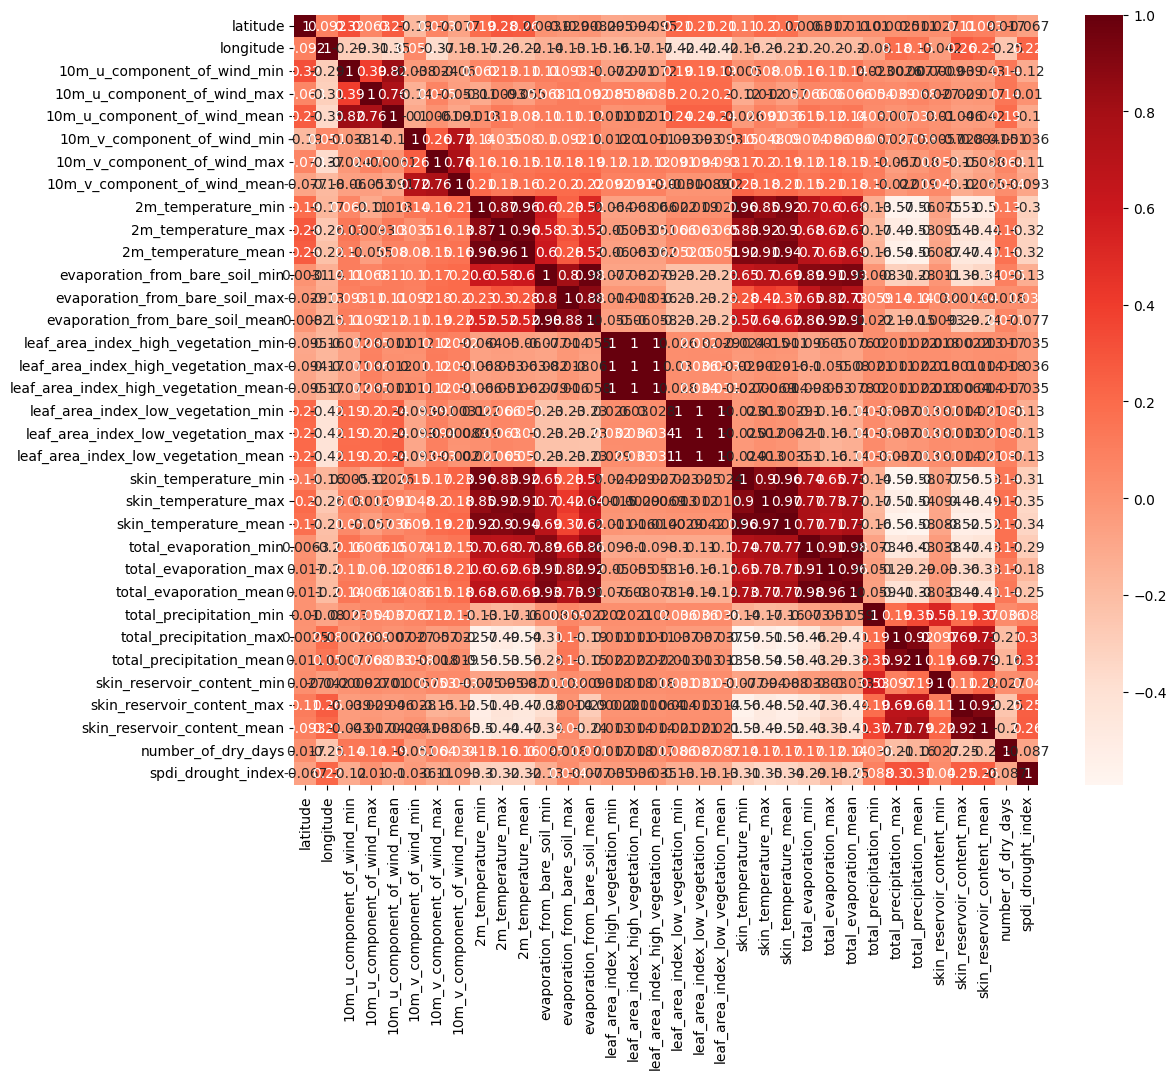

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = final_df.corr()
sb.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# Takes around 15 seconds to start and a few second to load new variables/years

app = dash.Dash(__name__)

# Build a plotting dataframe
plot_df = final_df.drop(['latitude', 'longitude'], axis=1)
plot_df_cols = plot_df.columns
plot_df.reset_index(inplace=True)
plot_df['date'] = pd.to_datetime(plot_df['date'])

app.layout = html.Div(
    style={'backgroundColor': 'white', 'padding': '20px'},  # Add padding
    children=[
        html.H1('Exploratory plots'),
        dcc.Dropdown(
            id='variable-dropdown',
            options=[{'label': col, 'value': col} for col in plot_df_cols],
            value='2m_temperature_mean'  # Set initial value
        ),
        html.Div(
            [
                html.Button('2020', id='year-button-1', n_clicks=0, className='button'),
                html.Button('2021', id='year-button-2', n_clicks=0, className='button'),
                html.Button('2022', id='year-button-3', n_clicks=0, className='button'),
            ],
            className='button-container'
        ),
        dcc.Graph(id='variable-plot')
    ]
)


@app.callback(
    Output('variable-plot', 'figure'),
    [
        Input('variable-dropdown', 'value'),
        Input('year-button-1', 'n_clicks'),
        Input('year-button-2', 'n_clicks'),
        Input('year-button-3', 'n_clicks')
    ]
)
def update_plot(selected_variable, n_clicks_year1, n_clicks_year2, n_clicks_year3):
    button_id = dash.callback_context.triggered[0]['prop_id'].split('.')[0]

    selected_year = {
        'year-button-1': 2020,
        'year-button-2': 2021,
        'year-button-3': 2022
    }.get(button_id, 2020)

    # Select yearly subset
    filtered_year_df = plot_df[plot_df['date'].dt.year == selected_year]

    # For each date create a box plot and add to figure
    fig = go.Figure()
    for date in pd.unique(filtered_year_df['date'].astype('string')):
        filtered_df = filtered_year_df[filtered_year_df['date'] == date]
        # Assign dates to the df subsets
        filtered_df[selected_variable].name = date

        fig.add_trace(go.Box(
            y=filtered_df[selected_variable].values,
            name=filtered_df[selected_variable].name,
            boxpoints='all',
            showlegend=False,
            jitter=0.7,  # add some jitter for a better separation between points
            pointpos=-2,
            marker=dict(color='skyblue')
        ))

    # Define layout for figure
    fig.update_layout(
        title={
            'text': f'Distribution of {selected_variable} in {selected_year}',
            'font': {'size': 20}  # Increase the font size
        },
        xaxis_title='Date',
        yaxis_title=selected_variable,
        font=dict(
            family='Times New Roman',
            size=14
        )
    )
    return fig


if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

In [ ]:
xarray_df = final_df.reset_index()
xarray_df['date'] = pd.to_datetime(xarray_df['date'])
xarray_df = xarray_df.set_index(['date', 'latitude', 'longitude'])

ds = xarray_df.to_xarray()
ds

<xarray.Dataset>
Dimensions:                               (date: 48, latitude: 27, longitude: 59)
Coordinates:
  * date                                  (date) datetime64[ns] 2020-05-01 .....
  * latitude                              (latitude) float64 36.07 ... 38.67
  * longitude                             (longitude) float64 -7.446 ... -1.645
Data variables: (12/32)
    10m_u_component_of_wind_min           (date, latitude, longitude) float64 ...
    10m_u_component_of_wind_max           (date, latitude, longitude) float64 ...
    10m_u_component_of_wind_mean          (date, latitude, longitude) float64 ...
    10m_v_component_of_wind_min           (date, latitude, longitude) float64 ...
    10m_v_component_of_wind_max           (date, latitude, longitude) float64 ...
    10m_v_component_of_wind_mean          (date, latitude, longitude) float64 ...
    ...                                    ...
    total_precipitation_mean              (date, latitude, longitude) float64 ...
    skin_reservoir_content_min            (date, latitude, longitude) float64 ...
    skin_reservoir_content_max            (date, latitude, longitude) float64 ...
    skin_reservoir_content_mean           (date, latitude, longitude) float64 ...
    number_of_dry_days                    (date, latitude, longitude) float64 ...
    spdi_drought_index                    (date, latitude, longitude) float64 ...

In [ ]:
plot_df[plot_df['2m_temperature_max']==np.max(plot_df['2m_temperature_max'])]['date'].values[0]#.index.values[0]



numpy.datetime64('2021-08-09T00:00:00.000000000')

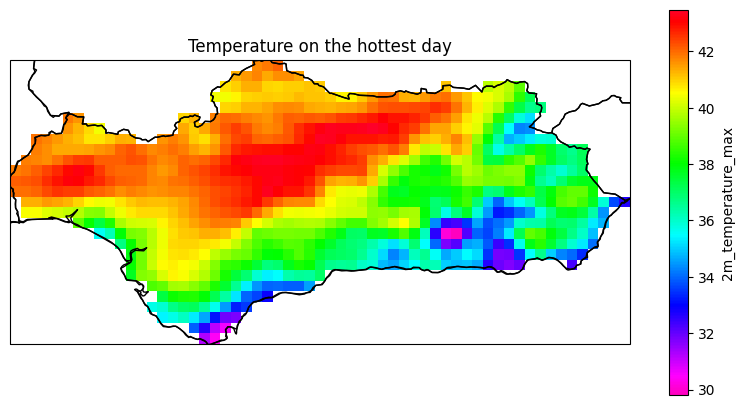

In [ ]:
# Load the GeoJSON file using geopandas
basemap = gpd.read_file("/content/drive/MyDrive/iberiaLow.json")

# Add basemap
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_geometries(basemap.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none')

# Find highest recorded temperature
hottest_day = plot_df[plot_df['2m_temperature_max']==np.max(plot_df['2m_temperature_max'])]['date'].values[0]

ds.sel(date=hottest_day, method='nearest')['2m_temperature_max'].plot(ax=ax, cmap='gist_rainbow_r')

# Layout
ax.set_title("Temperature on the hottest day")
ax.coastlines()

plt.show()

# Models

## Prepare training, test and validation data

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

X = final_df.drop(columns=['spdi_drought_index'])
y = final_df['spdi_drought_index']

In [ ]:
# Split the data into training and testing sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.33, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.33, random_state=42)

## Random Forest

In [ ]:
# Initialize and fit the random forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.11420426434383894


In [ ]:
# ! seeehr lang
# nicht ausführen
param_grid = {
    'n_estimators': [10, 25, 50, 100],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
    'min_samples_split': [2,4,8],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(rf_model, param_grid=param_grid)
grid_search.fit(X_val, y_val)
print(grid_search.best_params_)

# Make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

{'bootstrap': True, 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 9, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 0.5699659973182064


## Geospatial Model

array([[-1.13588690e+00],
       [ 3.52241020e+00],
       [ 9.06618190e-01],
       ...,
       [ 9.56060800e-08],
       [ 1.66894296e-08],
       [ 1.00000000e+00]])

In [ ]:
import numpy as np
import geopandas as gpd
from mgwr.gwr import MGWR, GWR
from mgwr.sel_bw import Sel_BW

X = final_df.reset_index().drop(columns=['date', 'spdi_drought_index', 'latitude', 'longitude']).values#.reshape((-1,1))
y = final_df['spdi_drought_index'].values.reshape((-1,1))

# Specify the coordinate values for the spatial data
coords = list(zip(final_df['longitude'], final_df['latitude']))

gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search(bw_min=2)

gwr_results = GWR(coords, y, X, np.array([gwr_bw])).fit()


/usr/local/lib/python3.10/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.10175e-16): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.10/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.06339e-16): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.10/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.02461e-16): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.10/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.08755e-16): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.10/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.04624e-16): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.10/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned m

In [ ]:
print(len(coords))
print(len(y))
print(len(X))


42912
42912
1330272


In [ ]:
sel_bw = Sel_BW(coords, y, X)
bw = sel_bw.search()

In [ ]:
# Perform Geographically Weighted Regression
mgwr_model = MGWR(coords, y, X, )

# Get the model results
print(mgwr_model.summary())


AttributeError: ignored

In [ ]:
feature_scores = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

total_precipitation_mean                0.083951
longitude                               0.082101
skin_temperature_mean                   0.074827
total_evaporation_min                   0.057680
10m_u_component_of_wind_max             0.057616
10m_u_component_of_wind_mean            0.051728
2m_temperature_min                      0.046054
evaporation_from_bare_soil_max          0.045708
2m_temperature_max                      0.044050
skin_temperature_max                    0.041233
skin_temperature_min                    0.038331
total_precipitation_max                 0.037317
10m_v_component_of_wind_min             0.034363
evaporation_from_bare_soil_min          0.033497
10m_u_component_of_wind_min             0.032959
number_of_dry_days                      0.032391
10m_v_component_of_wind_max             0.030636
10m_v_component_of_wind_mean            0.028593
evaporation_from_bare_soil_mean         0.027655
latitude                                0.023884
2m_temperature_mean 

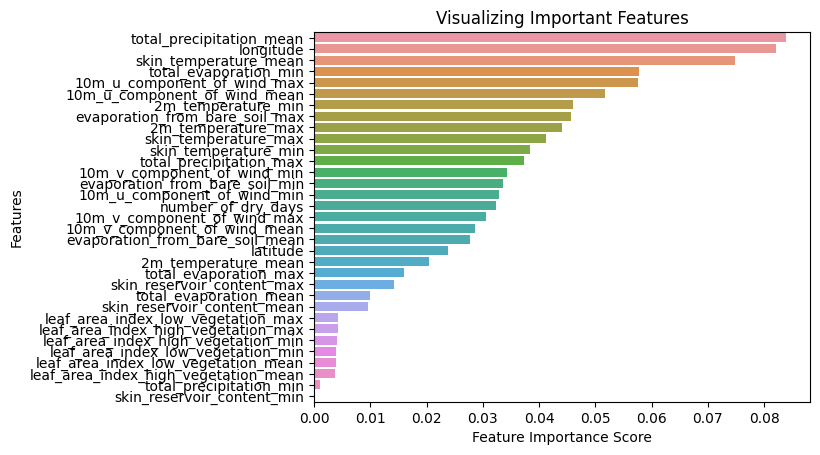

In [ ]:
# Creating a seaborn bar plot
sb.barplot(x=feature_scores, y=feature_scores.index)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

# Add title to the graph
plt.title("Visualizing Important Features")

# Visualize the graph
plt.show()

In [ ]:
results_df = pd.concat([X_test, y_test], axis=1)

results_df['pred_skin_reservoir_content'] = y_pred

results_df['pred_skin_reservoir_content'] = results_df['pred_skin_reservoir_content'].apply(lambda x: format(x, '.6f'))

In [ ]:
results_df

,coords,2m_temperature,skin_temperature,10m_v_component_of_wind,10m_u_component_of_wind,leaf_area_index_low_vegetation,leaf_area_index_high_vegetation,total_precipitation,total_evaporation,evaporation_from_bare_soil,pred_skin_reservoir_content,skin_reservoir_content
time,,,,,,,,,,,,
2022-06-20,91,33.63050,43.44485,2.682685,3.417621,0.501723,1.906477,0.000079,-0.000565,-0.000319,0.000010,0.000010
2020-07-06,430,38.59300,50.15093,1.037357,2.227331,2.783436,1.936284,0.000001,-0.001312,-0.001212,0.000000,0.000000
2021-07-23,118,34.15118,40.85638,0.905361,1.538809,2.210789,1.876504,0.000003,-0.000754,-0.000731,0.000000,0.000000
2021-07-19,609,26.20890,34.57195,1.944533,0.263338,1.777464,1.578021,0.000000,-0.000412,-0.000374,0.000000,0.000000
2020-08-23,74,34.41686,38.72650,0.285491,2.116113,2.819000,0.872785,0.000002,-0.000796,-0.000664,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,852,21.36785,26.60415,3.644716,-1.319750,2.362193,1.630245,0.000000,-0.002098,-0.001710,0.000000,0.000000
2020-08-13,884,30.06094,37.31380,1.363406,1.448484,1.932009,1.758273,0.000001,-0.000585,-0.000200,0.000000,0.000000
2021-06-15,359,24.64956,31.55782,1.050728,0.869572,2.260620,1.813569,0.000001,-0.001807,-0.001531,0.000000,0.000000


In [ ]:
import numpy as np
# ! Takes around 1 hour

# Create empty columns for region and country
drought_df['region'] = np.nan
drought_df['country'] = np.nan

# Iterate over all regions of GeoJSON
for region_name, region_data in regions.items():
    # Define masks for each region
    region_mask = region_data['geometry'].contains(drought_df['coords'])
    # Map the region name and country to the region mask containing all points/rows in a region
    drought_df.loc[region_mask, 'region'] = region_name
    drought_df.loc[region_mask, 'country'] = region_data['country']
    print(f'Region: {region_name}')
    print(f'Left: {len(drought_df[drought_df.isnull().any(axis=1)])}')

In [ ]:
import numpy as np
# ! Takes around 3 minutes

# Create empty columns for region and country
climate_df['region'] = np.nan
climate_df['country'] = np.nan

# Iterate over all regions of GeoJSON
for region_name, region_data in regions.items():
    # Define masks for each region
    region_mask = region_data['geometry'].contains(climate_df['coords'])
    # Map the region name and country to the region mask containing all points/rows in a region
    climate_df.loc[region_mask, 'region'] = region_name
    climate_df.loc[region_mask, 'country'] = region_data['country']

In [ ]:
drought_df = drought_df[~drought_df.isnull().any(axis=1)]

In [ ]:
climate_df = climate_df[~climate_df.isnull().any(axis=1)]

In [ ]:
import datetime

timestamps = ds['time'].values
timestamp_dates = [datetime.strftime(timestamp, '%Y-%m-%d') for timestamp in timestamps]

for time in timestamp_dates:
  ds.sel(time=time, method='nearest')['2m_temperature'].plot(cmap='gist_rainbow_r', figsize=(10, 5))

AttributeError: ignored

In [ ]:
import os
import datetime
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Define the variable and folder name
variable_name = '2m_temperature'
folder_name = variable_name + '_plots'

# Create the folder if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Get the time range
time_range = ds['time']

# Iterate over each time
for time in time_range:
    # Get the subset of data for the nearest time
    day_data = ds.sel(time=time, method='nearest')

    # Plot the variable
    plot = day_data[variable_name].plot(cmap='gist_rainbow_r', figsize=(10, 5))

    # Save the plot as an image in the folder
    file_name = f'{variable_name}_{time}.png'
    plot.figure.savefig(os.path.join(folder_name, file_name))


/usr/local/lib/python3.10/dist-packages/xarray/plot/utils.py:473: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kws)


KeyboardInterrupt: ignored

In [ ]:
!pip install imageio

In [ ]:
from PIL import Image
img, *imgs = [Image.open(f) for f in fns_image]
img.save(fp=save_gif_dir+gif_name+'1.gif', format='GIF', append_images=imgs,
     save_all=True, duration=200, loop=0)

In [ ]:

109962 * 3

329886

Data Scope (Rows):

- i only look at 3 years rn 2020 - 2022 + only Mai until end of August + only at 17 o'clock as it is the highest temperature based on literature = 2,5 Mio rows for all iberian regions and their according measuring station

- Etwa 1/10 der Punkt fallen leider weg, weil die GeoJSON vor allem b/Bildschirmfoto 2023-06-17 um 14.16.53.pngei Küstenregionen nicht vollständig präzise ist
Im Kontext der Betrachtung aber irrelevant weil direkte Küstenregionen kein primäres Opfer von Waldbränden etc sind
Siehe: https://gist.github.com/carmoreira/15d4b997483e68a709dea3d19d272a58 und Screenshot

- Somit bleiben 2.265.291 Messungen

- Komprimieren wir das auf die Regionen sind es nur noch 7749

- betrachten wir nur andalucia: 369 rows

- Betrachten wir Andalucia mit allen 894 Messstationen ergeben sich pro Jahr 109962 Messungen -> 329886 für die drei Jahre

- IDEA: split original df in region datasets but keep coords -> Spatial Heterogeneity and Depedency (https://medium.com/spatial-data-science/machine-learning-of-spatial-data-a-critical-review-88b1f9dcf857)
!!We can either incorporate spatial data and its features directly into the machine learning models and algorithms or create spatial features and feed the spatial data into non-spatial machine learning algorithms.


Data Scope (Columns):

- orginial variables are 13 columns including time, lat and lon
- Daten angereichert mit GeoJSON regions
- 33 Columns for the aggregated df if we take the min, max and mean for all variables
- Original Columns:
    - 10m_u_component_of_wind: Eastward wind at a height of 10 metres above the surface in meters per second
    - 10m_v_component_of_wind: Northward wind at a height of 10 metres above the surface in meters per second
    - 2m_temperature: Air temperature at 2m above the surface in Kelvin
    - evaporation_from_bare_soil: Amount of water that has evaporated from the Earth's surface in meters of water
    - leaf_area_index_high_vegetation: Surface area of all the high vegetation (evergreen, forest) leaves found in an area (0: no leaves)
    - leaf_area_index_low_vegetation: Surface area of all the low vegetation (crops, grass) leaves found in an area (0: no leaves)
    - skin_temperature: Surface temperature in Kelvin
    - total_evaporation: Accumulated amount of water that has evaporated from the Earth's surface in meters of water
    - total_precipitation: Accumulated water that falls to the Earth's surface in meters of water
    - skin_reservoir_content: Amount of water in surface skin in meters of water
- 21 Regions:
       Alentejo, Algarve, Andalucía, Aragón, Asturias,
       Cantabria, Castilla y León, Castilla-La Mancha, Cataluña,
       Centro, Extremadura, Galicia, Islas Baleares, La Rioja,
       Lisboa, Madrid, Murcia, Navarra, Norte, País Vasco,
       Valencia

- build own risk level based on perenctil of min max reseroirs + base it off Papers + new features



Models:

- Random Forest, Isolation Forest (bestenfalls PyTorch sonst sklearn) und dann AutoEncoder in Pytorch


Application:
- original idea Anomaly Detection for Soil Moisture
- Forecasting for Soil Moisture/Perciptation
- Interval forecasting for Soil Moisture/Perciptation (min max)
- spatiotemporal prediction
- Predict x-days with 0 soil mosisture? -> new feature (high drought risk)


Story:
- original idea was to detect direct nature disasters but they are not directly captured in the data/makes more sense to detect the breeding ground/requirements
- which is a vital indicator for misharvest, drought and wildfire
- becoming more prevalent with climate change especially in iberic peninsula region
- for example focus on Andalucia because it is an arid region and else how would I integrate the regions?
https://www.euronews.com/2022/10/14/spains-subtropical-fruit-market-is-ripening-heres-why
- Soil moisture plays a key role in the Earth’s hydrological cycle and meteorological and climatic processes. The information on soil moisture content is required for irrigation scheduling, crop yield prediction, studies on weather and climate change, monitoring and forecasting extreme weather events like floods and drought, and estimation of runoff and soil erosion. The accurate and timely estimation and forecasting of soil moisture are necessary for these applications. Machine learning (ML) algorithms, like artificial neural networks, support vector machines, decision trees, random forest, and so on, are widely used for soil moisture assessment (https://www.sciencedirect.com/science/article/abs/pii/B978032385214200001X)

Outlook:
- Models for each measurement station or apply advanced models which are capable of spatiotemporal consideration


Visualization/Evaluation:

- initial visualization of aggr_df for the iberian peninsula
- als grafik (gif was pro tag die anomaly scores oder das risiko von soil drought/low mositure der jeweiligen region anzeigt) jahr lässt sich auswählen



ToDos:

- EDA
- Find Application/Goal
- Comment (DocString)
- Documentation, Storyline
- Dependencies, Structure and Clean Notebooks

# Drought index:

paper:
http://dx.doi.org/10.3390/data2030022

data:
https://monitordesequia.csic.es/historico/

72193 stations per day only in andalucia

Daily -> Weekly:

Daily data were subject to careful quality control, which included identification of spurious data,
repeated records, and coding errors (see details in [24]). Daily series were converted to weekly series.
The sum of daily values was used for precipitation, while for the other variables the weekly mean was
estimated with an allowance for only one day of missing data. Relative humidity and temperature
Data 2017, 2, 22 3 of 10
data were combined to calculate the dew point temperature, which was used in the following steps of
the process. As drought indices are relative metrics and their calculation requires homogeneous time
periods, it was not possible to use “week” as the reference time step for calculations because the first
day of each year can fall on different days, and this propagates through the entire year. The occurrence
of leap years also potentially increased the inhomogeneity of the periods to be compared. For this
reason, each month was divided into four artificial “weekly” periods, the first from the 1st to the 8th
day, the second from the 9th to the 15th day, the third from the 16th to the 22nd day, and the fourth
from the 23rd day to the end of the month. This approach enabled interannual comparisons amongst
the various periods, which is essential for the calculation of drought indices.
Fragmented weekly data series were reconstructed using a gap-filling process. Missing data in
each objective series were filled using weighted averages of measurements made at nearby stations
(candidate series)


    Self-Calibrated Palmer Drought Indices (PDSI, scPDSI, PHDI, and Z-Index): These indices are commonly used to assess long-term drought conditions. They were calculated based on the method described in reference [33]. The calculation process involved using the available code from http://greenleaf.unl.edu/, which was modified to incorporate ETo calculated using the Penman-Monteith equation. The code was executed directly in the R programming language.

    Standardized Precipitation Index (SPI): The SPI is a widely used index to quantify precipitation anomalies and assess meteorological drought. It was calculated following the recommendations of the World Meteorological Organization (WMO) as described in reference [34]. The SPI calculation employed a two-parameter gamma distribution.

    Standardized Precipitation Evapotranspiration Index (SPEI): The SPEI is an extension of the SPI that incorporates both precipitation and evapotranspiration data. It provides a standardized measure of the combined deficit or surplus of water availability. The SPEI was calculated using a three-parameter log-logistic distribution and employed non-biased Probabilistic Weighted Moments (PWMs) to estimate the distribution parameters. More details about the calculation can be found in references [13] and [35].

    Standardized Precipitation Drought Index (SPDI): The SPDI is similar to the SPI but considers the duration and severity of precipitation deficits. It was obtained following the method described in reference [36]. However, instead of using the recommended General Extreme Value distribution (GEV), a three-parameter log-logistic distribution was used to avoid issues with extreme values and difficulties in performing the calculation. For further information, refer to reference [37].

# EDA

Benham: Machine Learning of Spatial Data

Global Moran’s I is an indicator of spatial autocorrelation and is a similarity index

The I index takes positive or negative values between −1 and +1. A positive value means similar values happen in close proximity, while a negative value shows that dissimilar values are spatially grouped
close to each other. A value close to zero shows no spatial autocorrelation for the variable, indicative of a spatially random process; in the latter case, the assumption of independence, essential for many statistical methods, is met.

Spatial Dependence:

However, most traditional machine learning algorithms do not consider the impact that the spatial dependence property may have on learning these association rules. For example, while we expect the crime rate at a block to be more similar to its neighboring blocks than the farther blocks, traditional machine learning algorithms, such as support vector machines (SVM) or neural networks have not been designed to incorporate this characteristic

Spatial Heterogeneity:

Another source of spatial heterogeneity is when the spatial dependence is different in various directions (anisotropy). For example, high precipitation patterns may be interrupted in a specific direction where the spatial topography of the terrain (mountains) blocks the clouds

Scale:

In many geographic studies, training occurs on data from a specific geographic area. This makes it challenging to use the trained model for other geographic regions because the distribution of the test and train data sets is not similar, due to spatial heterogeneity [ 61]. This means that the sampling strategy for the training data set is essential to cover the heterogeneity of the phenomena of interest over the spatial frame of study

In [ ]:
df.to_csv('ERA5_spain_df.csv')

In [ ]:
from google.colab import files
files.download("ERA5_spain_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from math import nan
from shapely.geometry import shape, Point

# Iterate over the rows in your dataframe
for index, row in df.iterrows():
   if row.isna().any():
      region = nan
      country = nan
      point = Point(row['longitude'], row['latitude'])

      # check each polygon to see if it contains the point
      for feature in geojson_data['features']:
          polygon = shape(feature['geometry'])
          if polygon.contains(point):
            region = feature['properties']['name']
            country = feature['properties']['CNTRY']

      df.loc[index, 'region'] = region
      df.loc[index, 'country'] = country
